In [21]:
# Import Packages
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
import matplotlib.pyplot as plt
import seaborn as sns
numpy2ri.activate()

Balancesampling = importr('BalancedSampling')
cube = Balancesampling.cube

In [23]:
def Var_bern(Y, Yhat, xi, pi):
    selected = np.where(xi == 1)[0]
    residuals_sq = (Y[selected] - Yhat[selected]) ** 2
    terms = residuals_sq * (1 - pi[selected]) / (pi[selected] ** 2)
    variance_estimate = terms.sum() / (len(Y) ** 2)
    return variance_estimate

def Var_cube(Y, X, xi, pi, N, max_iter=100, tol=1e-6):
    selected = np.where(xi == 1)[0]
    Y_sample = Y[selected]
    X_sample = X[selected, :]
    pi_sample = pi[selected]

    n, p = len(Y_sample), X_sample.shape[1]
    c = (n / (n - p)) * (1 - pi_sample)

    for _ in range(max_iter):
        M = sum((c[i] / pi_sample[i] ** 2) * np.outer(X_sample[i], X_sample[i]) for i in range(n))
        c_new = np.zeros(n)
        M_inv = np.linalg.inv(M)

        for k in range(n):
            x_k = X_sample[k]
            A = (x_k @ M_inv @ x_k) / pi_sample[k]
            disc = 1 + 4 * A * (1 - pi_sample[k])
            if disc < 0 or A == 0:
                c_new[k] = 1 - pi_sample[k]
            else:
                c_new[k] = (-1 + np.sqrt(disc)) / (2 * A)

        if np.max(np.abs(c_new - c)) < tol:
            break
        c = c_new

    weights = c / (pi_sample ** 2)
    XtW = (X_sample.T * weights)
    XtWX = XtW @ X_sample
    XtWY = XtW @ Y_sample
    b = np.linalg.solve(XtWX, XtWY)
    residuals = Y_sample - X_sample @ b

    variance_estimate = (c * residuals ** 2 / pi_sample ** 2).sum() / (N ** 2)
    return variance_estimate


(279008, 79) (279008,)


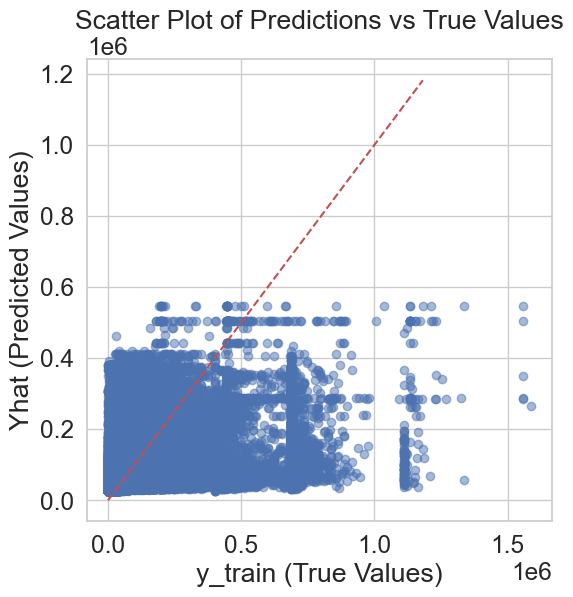

In [77]:
np.random.seed(0)
data_2021 = pd.read_csv('C:/Users/C/Desktop/active 1/CA_ACS_2021.csv', dtype={127: str}, low_memory=False)
data_2022 = pd.read_csv('C:/Users/C/Desktop/active 1/CA_ACS_2022.csv', dtype={127: str}, low_memory=False)

features = list(set([
    'DIVISION', 'PUMA', 'REGION', 'ST', 'AGEP', 'DDRS', 'DEAR', 'DEYE', 
    'DOUT', 'DPHY', 'DREM', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 
    'HINS6', 'HINS7', 'LANX', 'MAR', 'MIG', 'RELSHIPP', 'SCH', 'SCHL', 
    'SEMP', 'SEX', 'ANC', 'ANC1P', 'ANC2P', 'DIS', 'HICOV', 'HISP', 
    'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RACAIAN', 'RACASN', 'RACBLK', 
    'RACNH', 'RACNUM', 'RACPI', 'RACSOR', 'RACWHT', 'WAOB', 'FDEYEP', 
    'FDRATP', 'FDRATXP', 'FFERP', 'FFODP', 'FGCLP', 'FGCRP', 'FHIMRKSP', 
    'FHINS4P', 'FINDP', 'FINTP', 'FJWDP', 'FJWMNP', 'FJWRIP', 'FJWTRNSP', 
    'FLANP', 'FMARP', 'FMARHWP', 'FMARHYP', 'FMIGSP', 'FMILPP', 'FPERNP', 
    'FPINCP', 'FPOBP', 'FPOWSP', 'FRACP', 'FRELSHIPP', 'FSCHGP', 'FSCHLP', 
    'FSEMP', 'FSEXP', 'FWKHP', 'FWRKP', 'FYOEP'
]))

label = 'PINCP'

# 去除缺失值
train_1 = data_2021[(data_2021['PINCP'] > 0) & (data_2021['PINCP'].notna())]
train = train_1.sample(frac=0.1, random_state=0)
test = data_2022[(data_2022['PINCP'] > 0) & (data_2022['PINCP'].notna())]

X_train = train[features].values
y_train = train[label].values

X_test = test[features].values
y_test = test[label].values

# 第一阶段模型

In [ ]:
params_nonlinear1 = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'learning_rate': 0.001,
    'max_depth': 30,
    'reg_lambda': 1,
    'reg_alpha': 0.5
}



model = XGBRegressor(n_estimators=1000, **params_nonlinear1)
model.fit(X_train, y_train)
Yhat = model.predict(X_test)
Yhat_tr = model.predict(X_train)
err_tr = Yhat_tr - y_train

print(X_test.shape,y_test.shape)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, Yhat, alpha=0.5)
plt.xlabel('y_train (True Values)')
plt.ylabel('Yhat (Predicted Values)')
plt.title('Scatter Plot of Predictions vs True Values')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')  # 画出对角线
plt.grid(True)
plt.show()


#model = xgb.XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
#model.fit(X_train, y_train)
#pred1 = model.predict(X_train)

# 第二阶段残差建模
#residual = np.abs(y_train - pred1)
#model_residual = xgb.XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.1)
#model_residual.fit(X_train, residual)

# 测试集预测
#Yhat = model.predict(X_test)
#uncertainty = model_residual.predict(X_test)

#theta_true = y_test.mean()
#N = len(y_test)

#qn = norm.ppf(0.95)
#tau = 0.5

(10289,) (10289,)


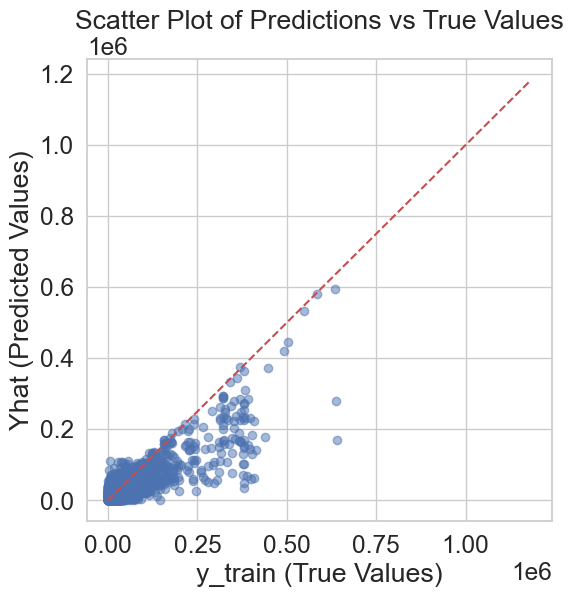

In [81]:
# Train error model
params_nonlinear2 = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 5 ,'reg_lambda': 2
}

model_err = XGBRegressor(n_estimators=500, **params_nonlinear2)
model_err.fit(X_train, err_tr)
uncertainty = np.abs(model_err.predict(X_test))

# Calculate statistics
theta_true = y_test.mean()
N = len(y_test)
qn = norm.ppf(0.95)
tau = 0.5

err_tr = Yhat_tr - y_train
un_tr = model_err.predict(X_train)
print(err_tr.shape,un_tr.shape)
plt.figure(figsize=(6, 6))
plt.scatter(np.abs(err_tr), np.abs(un_tr), alpha=0.5)
plt.xlabel('y_train (True Values)')
plt.ylabel('Yhat (Predicted Values)')
plt.title('Scatter Plot of Predictions vs True Values')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')  # 画出对角线
plt.grid(True)
plt.show()

In [95]:
from itertools import product

# 定义搜索空间
learning_rates = [0.01, 0.05, 0.1]
max_depths = [3, 5, 7]
reg_lambdas = [1, 2, 5]
reg_alphas = [0, 0.5, 1]
n_estimators_list = [100, 300, 500]

# 记录最优结果
best_config = None
best_metric = float('inf')  # 最小化 Std_2 - Std_3
best_result = None

# 网格搜索
for lr, depth, lam, alpha, nest in product(learning_rates, max_depths, reg_lambdas, reg_alphas, n_estimators_list):
    params_try = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'learning_rate': lr,
        'max_depth': depth,
        'reg_lambda': lam,
        'reg_alpha': alpha
    }
    model_err = XGBRegressor(n_estimators=nest, **params_try)
    model_err.fit(X_train, err_tr)
    uncertainty = np.abs(model_err.predict(X_test))

    # 运行模拟
    try:
        result1, _, _, _, _, _, _ = run_simulation(
            budget=0.2, N_trial=100, qn=qn, theta_true=theta_true,
            y_test=y_test, Yhat=Yhat, uncertainty=uncertainty,
            tau=tau, N=N
        )
        Std_1, Std_2, Std_3 = result1[0], result1[1], result1[2]

        # 满足条件再比较指标
        if Std_1 > Std_2:
            metric = Std_2 - Std_3
            if metric < best_metric:
                best_metric = metric
                best_config = {
                    'learning_rate': lr,
                    'max_depth': depth,
                    'reg_lambda': lam,
                    'reg_alpha': alpha,
                    'n_estimators': nest
                }
                best_result = (Std_1, Std_2, Std_3)

    except Exception as e:
        print(f"Error for config {params_try} with n_estimators={nest}: {e}")
        continue

# 输出结果
print("Best Config:", best_config)
print("Best Std_1, Std_2, Std_3:", best_result)
print("Best Metric (Std_2 - Std_3):", best_metric)


D:\Anaconda\Ana\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Config: {'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 100}
Best Std_1, Std_2, Std_3: (299.9664457685418, 227.97401786263418, 325.13143090814725)
Best Metric (Std_2 - Std_3): -97.15741304551307


In [83]:
# Experiment
# Single Trial
def single_trial(seed, pi, pe, budget, qn, theta_true, y_test, Yhat, uncertainty, N):
    np.random.seed(seed)

    results_bias_sq = []
    results_ci = []
    results_cv = []
    results_lb = []
    results_hb = []

    methods = ['uniform', 'poisson_active', 'cube_active', 'classical']

    # Poisson Uniform Sampling
    xi_1 = np.random.binomial(1, pe)
    est_1 = (Yhat + (y_test - Yhat) * xi_1 / pe).mean()
    Std_1 = np.sqrt(Var_bern(y_test, Yhat, xi_1, pe))
    Cf_1 = qn * Std_1
    lb_1, hb_1 = est_1 - Cf_1, est_1 + Cf_1
    results_bias_sq.append((est_1 - theta_true)**2)
    results_ci.append(2 * Cf_1)
    results_cv.append(int(lb_1 < theta_true < hb_1))
    results_lb.append(lb_1)
    results_hb.append(hb_1)

    # Poisson Active Sampling
    xi_2 = np.random.binomial(1, pi)
    est_2 = (Yhat + (y_test - Yhat) * xi_2 / pi).mean()
    Std_2 = np.sqrt(Var_bern(y_test, Yhat, xi_2, pi))
    Cf_2 = qn * Std_2
    lb_2, hb_2 = est_2 - Cf_2, est_2 + Cf_2
    results_bias_sq.append((est_2 - theta_true)**2)
    results_ci.append(2 * Cf_2)
    results_cv.append(int(lb_2 < theta_true < hb_2))
    results_lb.append(lb_2)
    results_hb.append(hb_2)

    # Cube Active Sampling Based On Yhat
    Yhat_r = numpy2ri.py2rpy(np.reshape(Yhat, (-1, 1)))
    pi_r = numpy2ri.py2rpy(pi)
    cube_result = cube(Yhat_r, prob=pi_r)
    xi_3 = np.zeros(N)
    xi_3[np.array(cube_result).astype(int) - 1] = 1
    est_3 = (Yhat + (y_test - Yhat) * xi_3 / pi).mean()
    Std_3 = np.sqrt(Var_cube(y_test - Yhat, Yhat.reshape(-1, 1), xi_3, pi, N))
    Cf_3 = qn * Std_3
    lb_3, hb_3 = est_3 - Cf_3, est_3 + Cf_3
    results_bias_sq.append((est_3 - theta_true)**2)
    results_ci.append(2 * Cf_3)
    results_cv.append(int(lb_3 < theta_true < hb_3))
    results_lb.append(lb_3)
    results_hb.append(hb_3)

    # Classical Simple Random Sampling
    xi_4 = np.random.binomial(1, pe)
    selected_samples_4 = y_test[xi_4 == 1]
    est_4 = selected_samples_4.mean()
    m = xi_4.sum()
    sample_var_4 = selected_samples_4.var(ddof=1)
    Std_4 = np.sqrt((1 - budget) * sample_var_4 / m)
    Cf_4 = qn * Std_4
    lb_4, hb_4 = est_4 - Cf_4, est_4 + Cf_4
    results_bias_sq.append((est_4 - theta_true)**2)
    results_ci.append(2 * Cf_4)
    results_cv.append(int(lb_4 < theta_true < hb_4))
    results_lb.append(lb_4)
    results_hb.append(hb_4)

    return results_bias_sq, results_ci, results_cv, results_lb, results_hb

# Simulation N Trials
def run_simulation(budget, N_trial, qn, theta_true, y_test, Yhat, uncertainty, tau, N):
    pi = np.minimum(tau * uncertainty / uncertainty.mean() * budget + (1 - tau) * budget, 1)
    pe = np.full(N, budget)

    results = Parallel(n_jobs=32)(
        delayed(single_trial)(seed, pi, pe, budget, qn, theta_true, y_test, Yhat, uncertainty, N)
        for seed in range(N_trial))

    Result1 = np.sqrt(np.mean([r[0] for r in results], axis=0))
    Result2 = np.mean([r[1] for r in results], axis=0)
    Result3 = np.mean([r[2] for r in results], axis=0)
    Result4 = np.mean([r[3] for r in results], axis=0)
    Result5 = np.mean([r[4] for r in results], axis=0)

    return Result1, Result2, Result3, Result4, Result5, budget, len(results)

In [85]:
# Main
N_trials = 100
budgets = np.arange(0.01, 0.26, 0.05)
results_list = [run_simulation(b, N_trials, qn, theta_true, y_test, Yhat, uncertainty, tau, N) for b in budgets]

columns = ['uniform', 'poisson_active', 'cube_active', 'classical', 'budget', 'SuccessCount']
Result1 = pd.DataFrame([x[0].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result2 = pd.DataFrame([x[1].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result3 = pd.DataFrame([x[2].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result4 = pd.DataFrame([x[3].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result5 = pd.DataFrame([x[4].tolist() + [x[5], x[6]] for x in results_list], columns=columns)

D:\Anaconda\Ana\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [86]:
Result1.to_csv("Census_Result1.csv", index=False)
Result2.to_csv("Census_Result2.csv", index=False)
Result3.to_csv("Census_Result3.csv", index=False)
Result4.to_csv("Census_Result4.csv", index=False)
Result5.to_csv("Census_Result5.csv", index=False)

print(Result1)
print(Result2)
print(Result3)
print(Result4)
print(Result5)

       uniform  poisson_active  cube_active    classical  budget  SuccessCount
0  1563.704146     1631.266474  1249.555959  1593.426689    0.01           100
1   639.609353      568.305386   585.837636   642.619924    0.06           100
2   402.881255      342.955287   404.244568   450.275181    0.11           100
3   312.050307      284.278148   364.225126   348.682398    0.16           100
4   281.015240      263.594681   245.216850   300.627284    0.21           100
       uniform  poisson_active  cube_active    classical  budget  SuccessCount
0  5178.863271     4807.454373  4752.015907  5854.626525    0.01           100
1  2068.800582     1900.912450  1880.124734  2342.422531    0.06           100
2  1488.230774     1352.103703  1344.481860  1683.807116    0.11           100
3  1198.497267     1081.127413  1074.463427  1352.903041    0.16           100
4  1014.594243      908.160487   903.485715  1145.131872    0.21           100
   uniform  poisson_active  cube_active  classical  

279008


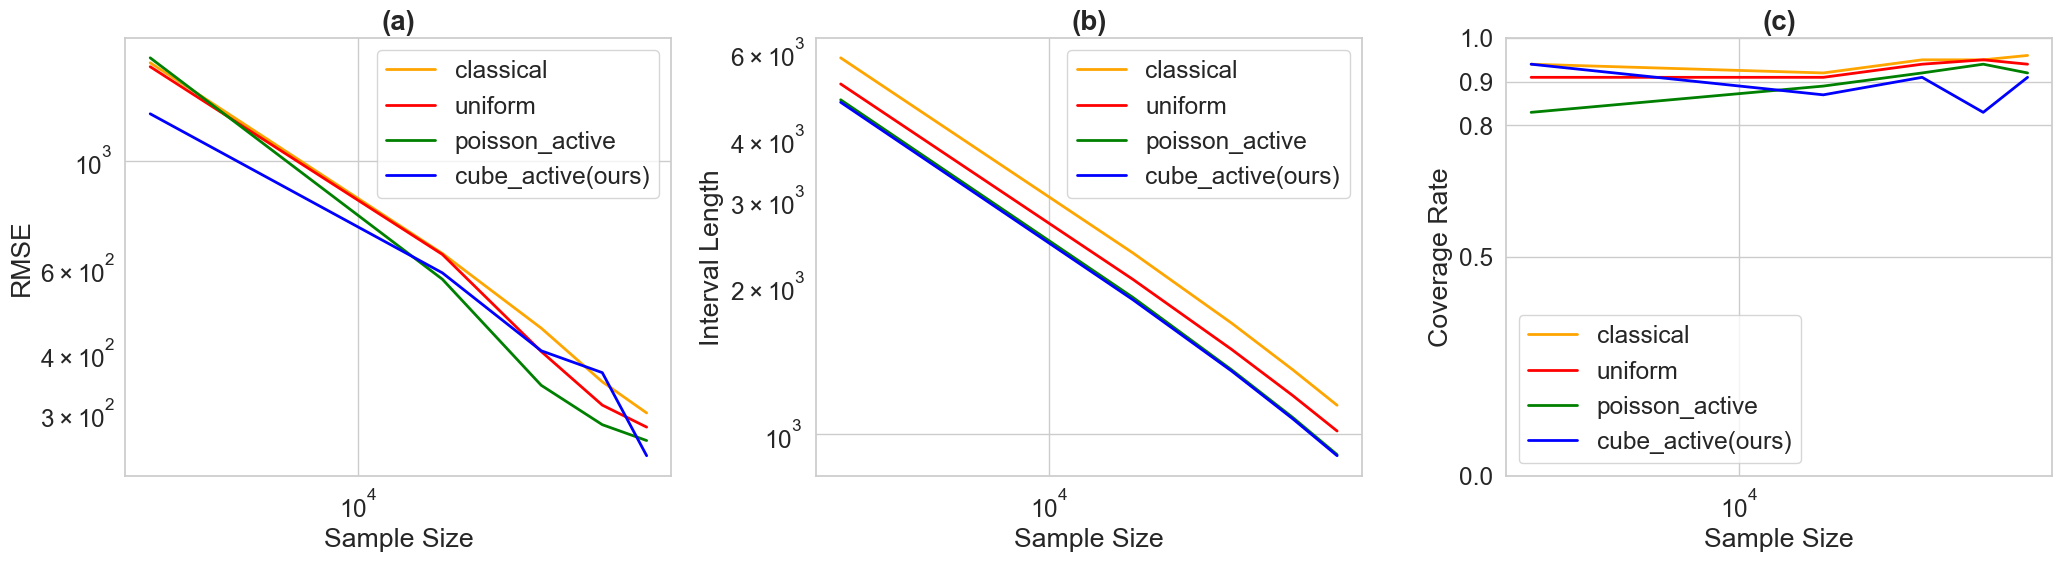

In [89]:
# Plot
Result1 = pd.read_csv("Census_Result1.csv")
Result2 = pd.read_csv("Census_Result2.csv")
Result3 = pd.read_csv("Census_Result3.csv")

sns.set(style="whitegrid", font_scale=1.6)

N = len(y_test) 
print(N)
# 调整方法顺序并将classical放到第一个，修改cube_active的标签
methods = ['classical', 'uniform', 'poisson_active', 'cube_active']  # 修改顺序
colors = {'uniform': 'red', 'poisson_active': 'green', 'cube_active': 'blue', 'classical': 'orange'}

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

def plot_results(ax, data, ylabel, log_scale=True, ylim_zero=False):
    for method in methods:
        # 修改cube_active的图例标签
        label = 'cube_active(ours)' if method == 'cube_active' else method
        ax.plot(data['budget'] * N, data[method], label=label, color=colors[method], linewidth=2)

    ax.set_xlabel("Sample Size")
    ax.set_ylabel(ylabel)
    ax.set_xscale('log')
    if log_scale:
        ax.set_yscale('log')
    if ylim_zero:
        ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid(True)

# 以下部分保持不变
# RMSE (Result1)
plot_results(axes[0], Result1, "RMSE", log_scale=True)
axes[0].set_title("(a)", fontsize=20, fontweight='bold') 

# Interval Length (Result2)
plot_results(axes[1], Result2, "Interval Length", log_scale=True)
axes[1].set_title("(b)", fontsize=20, fontweight='bold') 

# Coverage Rate (Result3)
plot_results(axes[2], Result3, "Coverage Rate", log_scale=False, ylim_zero=True)
axes[2].set_title("(c)", fontsize=20, fontweight='bold') 
axes[2].set_ylim(0, 1)  
axes[2].set_yticks([0, 0.5,0.8 , 0.9, 1])

plt.tight_layout()
plt.show()